In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
plt.rcParams['figure.figsize'] = (10, 8)

# Calculating Diffraction Patterns

https://en.wikipedia.org/wiki/Diffraction

Cool software package!

https://pypi.org/project/poppy/

Far-field diffraction:

https://stackoverflow.com/questions/20517309/converting-a-matlab-fft2-diffraction-example-into-python

## Single slit


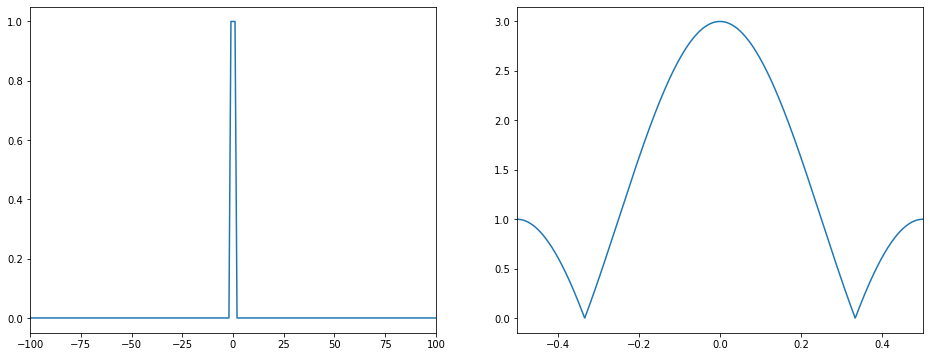

<function __main__.update(c=0, w=3, freq_range=0.5, show_real_imag=0)>

In [2]:
L = 2**10 
x = np.arange(-L, L, 1)

def update(c=0,w=3,freq_range=0.5,show_real_imag=0):
    # Mask
    M = ((x-c)>-w/2) * ((x-c)<w/2)
    # Diffraction pattern
    D = np.fft.fftshift(np.fft.fft(M))
    f = np.fft.fftshift(np.fft.fftfreq(len(M)))

    plt.figure(figsize=(16,6))
    plt.subplot(121)
    plt.plot(x,M)
    plt.xlim((-100,+100))
    plt.subplot(122)
    plt.plot(f,np.abs(D))
    if (show_real_imag):
        plt.plot(f,np.real(D))
        plt.plot(f,np.imag(D))
    plt.xlim((-freq_range,freq_range))

interact(update,c=(-100,100,1), w=(1,100,2),freq_range=(0.02,0.5,0.01), show_real_imag=(0,1,1))

## Double slit

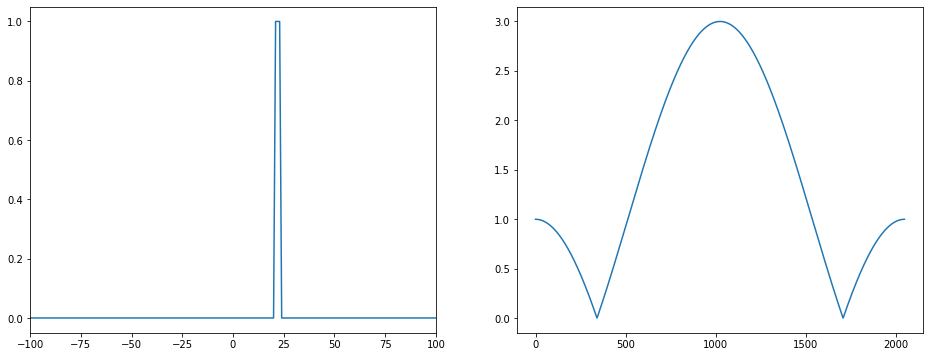

<function __main__.update(d=20, w=3, num_slits=1)>

In [3]:
L = 2**10 
x = np.arange(-L, L, 1)

def update(d=20,w=3, num_slits=1):
    # Mask
    M = ((x-d)>0) * ((x-d)<=w)
    if num_slits == 2:
        M += ((x+d)>0) * ((x+d)<=w)
    # Diffraction pattern
    D = np.fft.fftshift(np.fft.fft(M))
    
    plt.figure(figsize=(16,6))
    plt.subplot(121)
    plt.plot(x,M)
    plt.xlim((-100,+100))
    plt.subplot(122)
    plt.plot(np.abs(D))

interact(update,d=(0,100,1), w=(1,100,1), num_slits=(1,2,1))

## 2D Fraunhofer

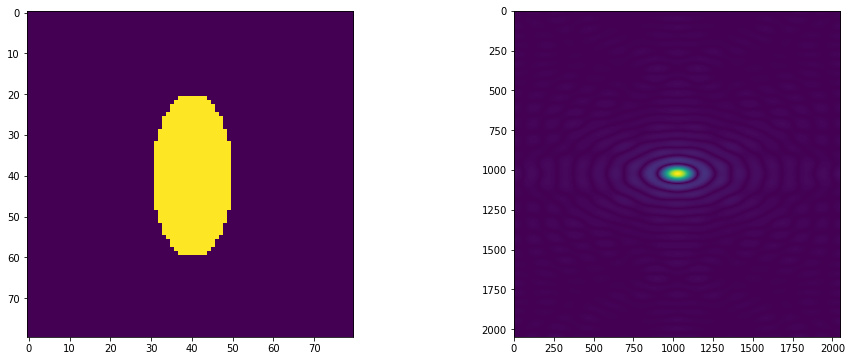

<function __main__.update(R=20)>

In [4]:
L = 2**10 
x = np.arange(-L, L, 1)
y = np.arange(-L, L, 1)

X, Y = np.meshgrid(x, y)

def update(R=20):
    # A circle
    #M = X**2 + Y**2 < R**2
    # An ellipse
    M = 4*X**2 + Y**2 < R**2
    # A square
    #M = (X**2<R**2) * (Y**2 < R**2)
    
    D1 = np.fft.fft2(M)
    D2 = np.fft.fftshift(D1)
    abs_image = np.abs(D2)

    plt.figure(figsize=(16,6))
    plt.subplot(121)
    n1= int(len(x)/2-40); n2 = int(len(x)/2+40)
    plt.imshow(M[n1:n2,n1:n2])
    plt.subplot(122)
    plt.imshow(abs_image)
    
interact(update,R=(0,30,1))

## Fresnel

Matlab code: https://stackoverflow.com/questions/20971945/fresnel-diffraction-in-two-steps

```
function U = fresnel_advance (U0, dx, dy, z, lambda)
% The function receives a field U0 at wavelength lambda
% and returns the field U after distance z, using the Fresnel
% approximation. dx, dy, are spatial resolution.

k=2*pi/lambda;
[ny, nx] = size(U0); 

Lx = dx * nx;
Ly = dy * ny;

dfx = 1./Lx;
dfy = 1./Ly;

u = ones(nx,1)*((1:nx)-nx/2)*dfx;    
v = ((1:ny)-ny/2)'*ones(1,ny)*dfy;   

O = fftshift(fft2(U0));

H = exp(1i*k*z).*exp(-1i*pi*lambda*z*(u.^2+v.^2));  

U = ifft2(O.*H); 
```



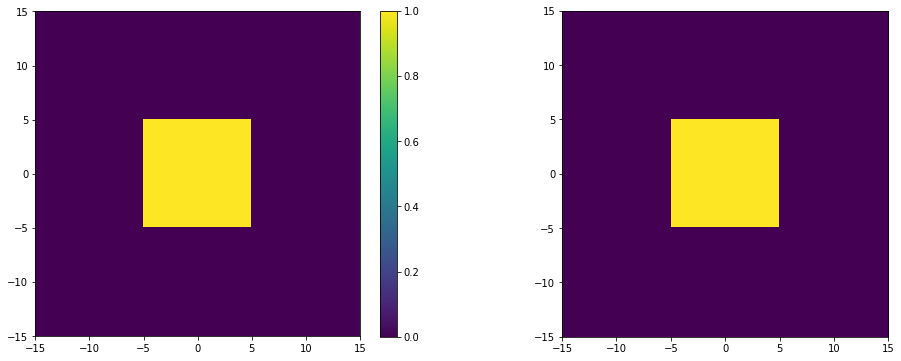

<function __main__.update(z=0, thr=0.8, cmax=1)>

In [5]:
# https://stackoverflow.com/questions/20971945/fresnel-diffraction-in-two-steps
    

def fresnel(M, dx, lam, z):  
    k=2*np.pi/lam
    # Take the Fourier transform
    Mf = np.fft.fft2(M)

    # Define frequency matrices
    f = np.fft.fftfreq(len(x), d=dx)
    FX,FY = np.meshgrid(f,f)

    # The transfer function for Fresnel diffraction
    #H=np.exp(1j*(2*np.pi/lam)*z)*np.sqrt(1+0j-(lam*FX)**2-(lam*FY)**2)
    H = np.exp(1j*k*z)*np.exp(-1j*np.pi*lam*z*(FX**2+FY**2))

    # Now apply the transfer function to the FT of the mask
    Mf2 = H*Mf

    # Now calculate the inverse FT
    return np.fft.ifft2(Mf2)

# Define size of image, set up grid
L = 30e-6 
N = 2**8
x = np.linspace(-L/2, L/2, N)
y = np.linspace(-L/2, L/2, N)
dx = x[1]-x[0]
X, Y = np.meshgrid(x, y)

# Wavelength
lam = 380e-9

# Distance to propagate the field
z = 5e-6

# Define the mask
R = 5e-6
# A square mask
M = (X**2 < R**2) * (Y**2 < R**2)
# An inverse square mask
#M = 1-(X**2 < R**2) * (Y**2 < R**2)
# A circle
#M = X**2 + Y**2 < R**2
# A inverse circle
#M = 1-(X**2 + Y**2 < R**2)
# A line
#M = X**2 < (R/5)**2
# A triangle
#R = 1e-6
#M = (X**2 < R**2) * (Y**2 < R**2) * (X>Y)



# in microns for the plot
dim=(-L/2*1e6, L/2*1e6, -L/2*1e6, L/2*1e6 )

def update(z=0, thr=0.8, cmax=1):
    M2 = fresnel(M, dx, lam, z*1e-6)
    plt.figure(figsize=(16,6))
    plt.subplot(121)
    plt.imshow(np.abs(M2)**2, extent=dim, vmax=cmax)
    plt.colorbar()
    plt.subplot(122)
    expose = np.abs(M2)**2 > thr
    plt.imshow(expose, extent=dim)
    
    
interact(update, z=(0,10,0.1),thr=(0.01,1,0.05), cmax=(0.01,2,0.01))